In [1]:
!nvidia-smi

Thu Mar 17 16:28:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    On   | 00000000:19:00.0 Off |                  N/A |
| 30%   31C    P8    18W / 350W |      5MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    On   | 00000000:1A:00.0 Off |                  N/A |
| 30%   

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


## Model

In [4]:
import torch
import torch.nn as nn

In [5]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [6]:
# GPU를 사용 가능하다면 device 값이 cuda가 되고, 아니라면 cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [7]:
print(device)
print("GPU usage>>", torch.cuda.is_available())

cuda
GPU usage>> True


In [8]:
# 학습에 사용할 파라미터
learning_rate = 0.001
training_epochs = 20
batch_size = 100

In [9]:
# 데이터로더를 사용하여 데이터를 다루기 위해서 데이터셋을 정의
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

In [10]:
# 데이터로더를 사용하여 배치 크기를 지정
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [11]:
# 클래스로 모델을 설계
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        # ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 두번째층
        # ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

In [12]:
# CNN 모델 정의
model = CNN().to(device)
model.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

In [13]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                   [-1, 10]          31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 0.19
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [14]:
# 비용 함수와 옵티마이저를 정의
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# 총 배치의 수를 출력
total_batch = len(data_loader)
print('Total batch : {}'.format(total_batch))

# 배치 사이즈가 100이고 배치 수가 600이므로 60,000개의 데이터 학습

Total batch : 600


In [16]:
# loss, accuracy 시각화
cost_list = [] 
accuracy_list = []

In [17]:
# 모델 train
for epoch in range(training_epochs):
    avg_cost = 0
    
    # X = images, Y = labels
    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device).cuda()
        Y = Y.to(device).cuda()
        
        #forward
        hypothesis = model(X).cuda()
        cost = criterion(hypothesis, Y)
        optimizer.zero_grad()    
        
        #backward
        cost.backward()
        
        # update
        optimizer.step()

        avg_cost += cost / total_batch

    # 학습을 진행하지 않을 것이므로 torch.no_grad()
    with torch.no_grad():
        X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
        Y_test = mnist_test.test_labels.to(device)

        prediction = model(X_test)
        correct_prediction = torch.argmax(prediction, 1) == Y_test
        accuracy = correct_prediction.float().mean()
        # print('Accuracy:', accuracy.item())
        
        accuracy_list.append(accuracy)
        cost_list.append(avg_cost)
    
    
    print('[Epoch: {:>4}] / cost = {:>.9} / accuracy = {:>.9}'.format(epoch + 1, avg_cost, accuracy))

/compuworks/anaconda3/envs/song/lib/python3.7/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/compuworks/anaconda3/envs/song/lib/python3.7/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[Epoch:    1] / cost = 0.222060099 / accuracy = 0.971399963
[Epoch:    2] / cost = 0.0611627363 / accuracy = 0.972599983
[Epoch:    3] / cost = 0.0453312695 / accuracy = 0.974699974
[Epoch:    4] / cost = 0.0366176181 / accuracy = 0.983799994
[Epoch:    5] / cost = 0.0299008526 / accuracy = 0.982899964
[Epoch:    6] / cost = 0.0254108775 / accuracy = 0.987499952
[Epoch:    7] / cost = 0.0201316215 / accuracy = 0.983699977
[Epoch:    8] / cost = 0.0179204606 / accuracy = 0.982299984
[Epoch:    9] / cost = 0.0153871914 / accuracy = 0.985599995
[Epoch:   10] / cost = 0.0131179383 / accuracy = 0.986299992
[Epoch:   11] / cost = 0.00999143254 / accuracy = 0.983500004
[Epoch:   12] / cost = 0.00926900376 / accuracy = 0.986799955
[Epoch:   13] / cost = 0.00817807857 / accuracy = 0.988999963
[Epoch:   14] / cost = 0.0070477156 / accuracy = 0.986499965
[Epoch:   15] / cost = 0.00572700286 / accuracy = 0.985899985
[Epoch:   16] / cost = 0.0062630116 / accuracy = 0.986199975
[Epoch:   17] / cost 

In [18]:
cost_list_arr = []
accuracy_list_arr = []
for cost, accuracy in zip(cost_list, accuracy_list):
    cost_list_arr.append(cost.detach().cpu().numpy())
    accuracy_list_arr.append(accuracy.detach().cpu().numpy())

In [19]:
len(cost_list_arr), len(accuracy_list_arr)

(20, 20)

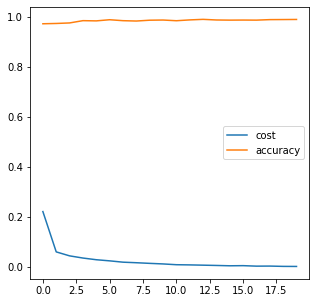

In [21]:
import matplotlib.pyplot as plt
import numpy as np

X = np.arange(0, training_epochs)

plt.figure(figsize=(5,5)) 
plt.plot(X, cost_list_arr, label = 'cost')
plt.plot(X, accuracy_list_arr, label = 'accuracy')
plt.legend()
plt.show()

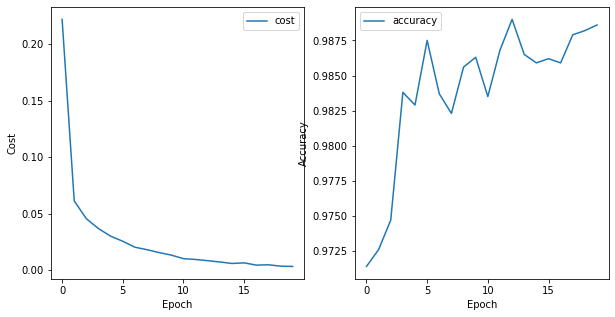

In [22]:
plt.figure(figsize=(10,5)) 
plt.subplot(1,2,1) 
plt.xlabel('Epoch') 
plt.ylabel('Cost') 
plt.plot(X, cost_list_arr, label = 'cost')
plt.legend()

plt.subplot(1,2,2) 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.plot(X, accuracy_list_arr, label = 'accuracy')

plt.legend()
plt.show()

In [23]:
from PIL import Image
import torchvision.transforms as transforms

In [24]:
image = Image.open("555.jpg")
image = image.convert("L").resize((28,28))
tf = transforms.ToTensor()
image = tf(image)
image.shape, image.dtype

(torch.Size([1, 28, 28]), torch.float32)

In [25]:
image = image.view(len(image), 1, 28, 28).float().to(device)
prediction = model(image)
correct_prediction = torch.argmax(prediction)
correct_prediction.item()

5

In [26]:
image = Image.open("777.jpg")
image = image.convert("L").resize((28,28))
tf = transforms.ToTensor()
image = tf(image)
image = image.view(len(image), 1, 28, 28).float().to(device)
prediction = model(image)
correct_prediction = torch.argmax(prediction)
correct_prediction.item()

3